In [1]:
from __future__ import print_function, division, absolute_import

from copy import copy
# python imports
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model
#import cobra_utils as wnql

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *

from cobrame.core.component import (Constraint, ProcessedProtein, Complex,
                                    TranslatedGene, TranscribedGene, Metabolite, Ribosome,
                                    GenericComponent,GenerictRNA,RNAP)

print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


In [2]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
bsub_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')
bsub_ref_directory = join(flat_files.ecoli_files_dir, 'Bacillus_subtilis_subsp_subtilis_str_168.xml')

#eco = wnql.io.load_model(eco_directory,format='json')
bsub = cobra.io.load_json_model(bsub_directory)
bsub_ref = cobra.io.read_sbml_model(bsub_ref_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

<Solution 0.12 at 0x7f1bd1d75978>

In [3]:
with open('./me_models/iYO844b.pickle', 'rb') as f:
    me = pickle.load(f)
with open('./me_models/final/iYO844b.pickle', 'rb') as f:
    me_bkp = pickle.load(f)
with open('./me_models/final/iJL1678b.pickle', 'rb') as f:
    ecome = pickle.load(f)

### Checking genes of transcriptomics

In [17]:
ecoli_gene_df = pd.read_csv('/home/jt/UCSD/untitled/ecoli_gene_dict.csv',sep='\t',index_col=0)
ecoli_res_df = pd.read_csv('/home/jt/UCSD/untitled/gene_list.csv',delim_whitespace=True, usecols=[0,1],index_col=1)
ecoli_essentiality = pd.read_csv('./ecoli_essentiality.csv',index_col=0)

In [20]:
genes_in_model_df = pd.DataFrame(index=ecoli_res_df.index,columns=['locus','in_model','essentiality'])
for gene in ecoli_res_df.index:
    if gene not in ecoli_gene_df.index:
        print(gene, 'not in DB')
        continue
    locus_id = ecoli_gene_df.loc[gene]['Accession-1']
    genes_in_model_df.loc[gene]['locus'] = locus_id
    if locus_id in ecoli_essentiality.index:
        genes_in_model_df.loc[gene]['essentiality'] = ecoli_essentiality.loc[locus_id]['me']
    if get_reactions_of_met(ecome,'RNA_'+locus_id,verbose=False):
        genes_in_model_df.loc[gene]['in_model'] = 1
    else:
        genes_in_model_df.loc[gene]['in_model'] = 0

erfK not in DB
fliY not in DB
mdoD not in DB
mdoG not in DB
ybiS not in DB
ynhG not in DB


In [29]:
genes_in_model_df[genes_in_model_df['essentiality'] == 'e']

,locus,in_model,essentiality
Description,,,
bamA,b0177,1,e
bamC,b2477,1,e
lolA,b0891,1,e
lpp,b1677,1,e


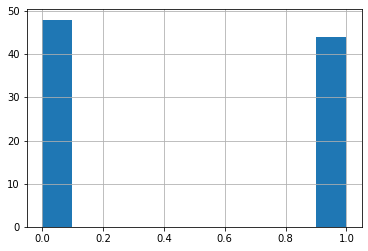

In [46]:
genes_in_model_df['in_model'].hist()

In [32]:
locus_id

'b1857'

In [4]:
metabolites = [met.id for met in me.metabolites]

In [ ]:
gap_mets = test_metabolite_production(me,metabolites,muf = 0.)

Updating model with kdeg = 0 for mu = 0


/home/jt/UCSD/cobrame-master/cobrame/core/reaction.py:852 UserWarning: RNA Polymerase () not found
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (cu_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (zn2_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (cbl1_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (cobalt2_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (fe2_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (dpm_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (sheme_c) does not have formula


biomass optimal 0.2040278333504854
protein_biomass optimal 0.09281173240853399
mRNA_biomass optimal 0.0001567097695472517
tRNA_biomass optimal 0.0009528713131074075
rRNA_biomass optimal 0.006858865315526063
ncRNA_biomass optimal 0.0
DNA_biomass optimal 0.0


In [11]:
a = get_reactions_of_met(me,'ncRNA_biomass',s=0)

( ncRNA_biomass_to_biomass 0.0 1000.0 ) 	 ncRNA_biomass --> biomass
( transcription_TU_BSU_misc_RNA_2 0.0 1000.0 ) 	 4.27350427350427e-6*mu BSU00550-MONOMER + 4.27350427350427e-6*mu BSU01010-MONOMER + 4.27350427350427e-6*mu BSU16600-MONOMER + 4.27350427350427e-6*mu BSU27320-MONOMER + 4.27350427350427e-6*mu CPLX8J2-30 + 96 atp_c + 93 ctp_c + 75 gtp_c + 90 utp_c --> RNA_BSU_misc_RNA_2 + 113.07415565399998 ncRNA_biomass + 354 ppi_c
( DM_ncRNA_biomass 0 1000 ) 	 ncRNA_biomass --> 
( DM_RNA_BSU_misc_RNA_2 0.0 1000.0 ) 	 RNA_BSU_misc_RNA_2 + 113.07415565399998 ncRNA_biomass --> 


In [5]:
GE_dict_m = gene_essentiality(bsub, model_type = 'm',  lim = 0.01, NP = 20)

NameError: name 'gene_essentiality' is not defined

In [5]:
GE_dict_me = gene_essentiality(me, model_type = 'me',  lim = 0.01, NP = 20, initial_f=0)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 96.237275 seconds
Finished substituting S,lb,ub in 3.428821 seconds
Finished makeME_LP in 0.698816 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.5 0.5 1
Finished substituting S,lb,ub in 3.695689 seconds
Finished makeME_LP in 0.799448 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 3.540666 seconds
Finished makeME_LP in 0.687764 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 3.366766 seconds
Finished makeME_LP in 0.670897 seconds
Getting MINOS parameters from ME_NLP...
4 0.0625 0.0625 0.125 0.0625 optimal
Finished substituting S,lb,ub in 3.386763 seconds
Finished makeME_LP in 0.711594 seconds
Getting MINOS parameters from ME_NLP...
5 0.09375 0.09375 0.125 0.09375 optimal
Finished substituting S,lb,ub in 3.503842 seconds
Finished makeME_LP in 0.690991 seconds
Getting MINOS parameters 

In [10]:
# Create one dict
GE_dict = {}
for key in GE_dict_me.keys():
    GE_dict[key] = {}
    try:
        GE_dict[key]['m'] = GE_dict_m[key]
    except:
        GE_dict[key]['m'] = None
    GE_dict[key]['me'] = GE_dict_me[key]
    
for key in GE_dict_m.keys():
    if key not in GE_dict.keys():
        GE_dict[key] = {}
        GE_dict[key]['m'] = GE_dict_m[key]
        try:
            GE_dict[key]['me'] = GE_dict_me[key]
        except:
            GE_dict[key]['me'] = None        
GE_dict

{'BSU00110': {'m': '0', 'me': '0'},
 'BSU00180': {'m': '0', 'me': '0'},
 'BSU00140': {'m': '0', 'me': '0'},
 'BSU00410': {'m': None, 'me': '0'},
 'BSU00270': {'m': '0', 'me': '0'},
 'BSU00120': {'m': '0', 'me': '0'},
 'BSU00730': {'m': '0', 'me': '0'},
 'BSU00150': {'m': '0', 'me': '0'},
 'BSU00090': {'m': '0', 'me': '0'},
 'BSU00680': {'m': '0', 'me': '0'},
 'BSU00760': {'m': 'e', 'me': 'e'},
 'BSU00500': {'m': 'e', 'me': 'e'},
 'BSU00460': {'m': 'e', 'me': 'e'},
 'BSU00380': {'m': '0', 'me': 'e'},
 'BSU00740': {'m': 'e', 'me': 'e'},
 'BSU00750': {'m': 'e', 'me': 'e'},
 'BSU00130': {'m': None, 'me': 'e'},
 'BSU00280': {'m': 'e', 'me': 'e'},
 'BSU00550': {'m': None, 'me': 'e'},
 'BSU00510': {'m': 'e', 'me': 'e'},
 'BSU00810': {'m': None, 'me': '0'},
 'BSU00980': {'m': None, 'me': '0'},
 'BSU00930': {'m': '0', 'me': '0'},
 'BSU00770': {'m': 'e', 'me': 'e'},
 'BSU00790': {'m': 'e', 'me': 'e'},
 'BSU00820': {'m': None, 'me': 'e'},
 'BSU00780': {'m': 'e', 'me': 'e'},
 'BSU01070': {'m': Non

In [11]:
with open("./me_models/GE_dict.pickle", "wb") as outfile:
    pickle.dump(GE_dict, outfile)

In [10]:
r = get_reactions_of_met(me,'protein_BSU04560',0)

( formation_BSU04560-MONOMER 0.0 1000.0 ) 	 protein_BSU04560 --> BSU04560-MONOMER
( translation_BSU04560 0.0 1000.0 ) 	 10fthf_c + 0.00150854700854701*mu BSU01120-MONOMER + 4.27350427350427e-6*mu BSU01390-MONOMER + 4.27350427350427e-6*mu BSU15720-MONOMER + 4.27350427350427e-6*mu BSU15730-MONOMER + 0.00150854700854701*mu BSU16500-MONOMER + 4.27350427350427e-6*mu BSU16520-MONOMER + 8.54700854700855e-6*mu BSU16630-MONOMER + 4.27350427350427e-6*mu BSU28870-MONOMER + 4.27350427350427e-6*mu BSU35290-MONOMER + 0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_BSU04560 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 33 ala__L_c + 9 arg__L_c + 14 asn__L_c + 19 asp__L_c + 353.0 + 1.59089163237311*(mu + 0.3915)/mu atp_c + 4 cys__L_c + 4.27350427350427e-6*mu generic_RF + 0.00150854700854701*mu generic_Tuf + 20.0 generic_tRNA_AAA_lys__L_c + 9.0 generic_tRNA_AAC_asn__L_c + 5.0 generic_tRNA_AAG_lys__L_c + 5.0 generic_tRNA_AAU_asn__L_c + 8.0 gen

In [17]:
bsub.solution.f

0.11796638935761272

In [61]:
get_metabolites_from_pattern(me,'cl_c')

['shcl_c']

In [113]:
met = 'protein_b3035'
print(eco_me.metabolites.get_by_id(met).name)
print_reactions_of_met(eco_me,met,1)

In [6]:
met = 'fmn_c'
print(me.metabolites.get_by_id(met).name)
print_reactions_of_met(me,met,-1)

FMN C17H19N4O9P


NameError: name 'print_reactions_of_met' is not defined

In [57]:
for met in bsub.metabolites:
    if 'complex' in met.name:
        print(met.id, met.name)

In [15]:
eco_me.metabolites.get_by_id('GRXB-MONOMER_mod_Oxidized').formula_weight

24349.923540000003

In [5]:
eco_me.metabolites.get_by_id('heme_c').formula

KeyError: 'heme_c'

In [15]:
bsub.metabolites.get_by_id('ACP_c').formula

'HX'

In [42]:
me.reactions.DNA_replication.metabolites

{<Metabolite datp_c at 0x7f6228fa36a0>: -0.246051501452,
 <Metabolite dctp_c at 0x7f6228fa35f8>: -0.253948498548,
 <Metabolite dgtp_c at 0x7f6228fa31d0>: -0.253948498548,
 <Metabolite dttp_c at 0x7f6228fa33c8>: -0.246051501452,
 <Metabolite ppi_c at 0x7f622fe6b828>: 1,
 <Constraint DNA_biomass at 0x7f622d17b6a0>: 0.3079428373534753}

In [37]:
r = get_reactions_of_met(bsub,'ac_c',0)

( ACS 0.0 999999.0 ) 	 ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c
( ADPDA -999999.0 999999.0 ) 	 26dapime_c + h2o_c <=> 26dap_LL_c + ac_c
( ALDD2x 0.0 999999.0 ) 	 acald_c + h2o_c + nad_c --> ac_c + 2.0 h_c + nadh_c
( ACODA_1 0.0 999999.0 ) 	 acorn_c + h2o_c --> ac_c + orn__L_c
( CYSS_2 0.0 999999.0 ) 	 acser_c + h2s_c --> ac_c + cys__L_c
( AHSERL4 -999999.0 999999.0 ) 	 acser_c + trdrd_c + tsul_c <=> ac_c + cys__L_c + h_c + so3_c + trdox_c
( AGDC 0.0 999999.0 ) 	 acgam6p_c + h2o_c --> ac_c + gam6p_c
( AHSERL3 -999999.0 999999.0 ) 	 acser_c + seln_c <=> ac_c + scys__L_c
( SLCYSS 0.0 999999.0 ) 	 acser_c + tsul_c --> ac_c + scys__L_c
( ACKr -999999.0 999999.0 ) 	 ac_c + atp_c <=> actp_c + adp_c
( ACt2r -999999.0 999999.0 ) 	 ac_e + h_e <=> ac_c + h_c


In [31]:
i=0
for rxn in me.reactions:
    rule = rxn.gene_reaction_rule
    if 'dummy' in rxn.id:
        i = i + 1

print(i)

182


In [7]:
eco_me.reactions.ATPM.gene_reaction_rule

''

In [25]:
rxn_id = 'PYRt2rpp'
eco.reactions.get_by_id(rxn_id).reaction
eco_me.reactions.SELGTHR2_FWD_CPLX_dummy.gene_reaction_rule

''